# Adler project

Work on EAGLE lens models: source reconstructions, synthetic imaging, comparison to true maps, ...


### Imports
`gleam` imports must happen from root of the directory, i.e. `/Users/phdenzel/adler/`.
This is why `..` is appended to the path.


In [1]:
import sys
sys.path.append('..')
import os
import re
import numpy as np
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as plt

from gleam.multilens import MultiLens
from gleam.reconsrc import ReconSrc
from gleam.glass_interface import glass_renv, filter_env, export_state
glass = glass_renv()

%load_ext skip_kernel_extension


### Reading data
Reading in all relevant files as dictionaries with ids as keys and list of filenames as values


In [2]:
rdir = "/Users/phdenzel/adler"
jsondir = rdir+"/json/"
statedir = rdir+"/states/v2/"
kappadir = rdir+"/kappa/"
keys = ["H1S0A0B90G0", "H1S1A0B90G0", "H2S1A0B90G0", "H2S2A0B90G0", "H2S7A0B90G0",
        "H3S0A0B90G0", "H3S1A0B90G0", "H4S3A0B0G90", "H10S0A0B90G0", "H13S0A0B90G0",
        "H23S0A0B90G0", "H30S0A0B90G0", "H36S0A0B90G0", "H160S0A90B0G0",
        "H234S0A0B90G0"]


In [3]:
def an_sorted(data):
    """
    Perform an alpha-numeric, natural sort

    Args:
        data <list> - list of strings

    Kwargs:
        None

    Return:
        sorted <list> - the alpha-numerically, naturally sorted list of strings
    """
    def convert(text):
        return int(text) if text.isdigit() else text.lower()

    def an_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=an_key)


ls_jsons = an_sorted([os.path.join(jsondir, f) for f in os.listdir(jsondir)
                      if f.endswith('.json')])
ls_states = an_sorted([os.path.join(statedir, f) for f in os.listdir(statedir)
                       if f.endswith('.state')])
ls_kappas = an_sorted([os.path.join(kappadir, f) for f in os.listdir(kappadir)
                       if f.endswith('.kappa.fits')])


In [4]:
jsons = {k: [f for f in ls_jsons if k in f] for k in keys}
filtered_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_filtered.state')] for k in keys}
ls_states = [f for f in ls_states if not f.endswith('_filtered.state')]

prefiltered_fsynth10_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf10.state')] for k in keys}
prefiltered_fsynth25_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf25.state')] for k in keys}
prefiltered_fsynth50_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf50.state')] for k in keys}
ls_states = [f for f in ls_states if not (f.endswith('_filtered_synthf10.state')
                                          or f.endswith('_filtered_synthf10.state')
                                          or f.endswith('_filtered_synthf10.state'))]

synthf10_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf10.state')] for k in keys}
synthf25_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf25.state')] for k in keys}
synthf50_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf50.state')] for k in keys}
ls_states = [f for f in ls_states if not (f.endswith('_synthf10.state')
                                          or f.endswith('_synthf25.state')
                                          or f.endswith('_synthf50.state'))]

states = {k: [f for f in ls_states if k in f] for k in keys}

kappa_map_files = {k: [f for f in ls_kappas if k in f] for k in keys}


### Inspection

The ensemble of a single state file is used

In [5]:
# select a single file
print("\n# Selected file")
key = keys[0]
idx = 0
json = jsons[key][0]
state = filtered_states[key][idx]
state = states[key][idx]
print(json)
print(state)


# Selected file
/Users/phdenzel/adler/json/H1S0A0B90G0.json
/Users/phdenzel/adler/states/v2/H1S0A0B90G0.state


In [6]:
# gleamobject
print("\n# gleamobject")
with open(json) as f:
    ml = MultiLens.from_json(f)
print(ml.__v__)


# gleamobject


N                   	1
filepaths           	['/Users/phdenzel/adler/json/H1S0A0B90G0.json']
files               	['H1S0A0B90G0.json']
fs                  	[LensObject(@[0.0000, -0.0000])]
bands               	['']
naxis1              	[161]
naxis2              	[161]
naxis_plus          	[None]
structure           	(161, 161, 1)
roi                 	[ROISelector(161, 161)]
lens_objects        	[LensObject(@[0.0000, -0.0000])]
lens                	[<0.0000, -0.0000>]
srcimgs_xy          	[[[97.0, 62.0], [57.0, 69.0], [71.0, 57.0], [81.0, 107.0]]]
light_model         	[{}]


In [7]:
# recon_src
print("\n# recon_src")
args = (ml, state)
kwargs = dict(M=20, verbose=1)
recon_src = ReconSrc(*args, **kwargs)
#recon_src.chmdl()  # move to a single ensemble model


# recon_src


lensobject          	LensObject(@[0.0000, -0.0000])
gls                 	<glass.environment.Environment instance at 0x11534e440>
mask                	[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
M                   	20
N                   	41


In [8]:
# inverse projection matrix
print("\n# inverse projection matrix")
Mij_p = recon_src.inv_proj_matrix()
print(type(Mij_p))
print(Mij_p.shape)


# inverse projection matrix


<class 'scipy.sparse.csc.csc_matrix'>
(25921, 1681)


In [9]:
# (inverse of the inverse) projection matrix
print("\n# projection matrix (TODO: not an actual inverse yet)")
Mp_ij = recon_src.proj_matrix()
print(type(Mp_ij))
print(Mp_ij.shape)


# projection matrix (TODO: not an actual inverse yet)


<class 'scipy.sparse.csc.csc_matrix'>
(25921, 1681)


In [10]:
# image plane data arrays
print("\n# image plane data arrays")
data = recon_src.d_ij()  # 1d lens plane data
print(type(data))
print(data.shape)
lmap = recon_src.lens_map()  # 2d lens plane data
print(type(lmap))
print(lmap.shape)
print("\n# source plane data arrays")
# source plane data arrays
rsrc = recon_src.d_p()  # 1d source plane data
print(type(rsrc))
print(rsrc.shape)
rsrc_map = recon_src.plane_map()  # 2d source plane data
print(type(rsrc_map))
print(rsrc_map.shape)

# synthetic image
print("\n# synthetic image")
reproj = recon_src.reproj_map()
print(type(reproj))
print(reproj.shape)


# image plane data arrays
<type 'numpy.ndarray'>
(25921,)
<type 'numpy.ndarray'>
(161, 161)

# source plane data arrays


<type 'numpy.ndarray'>
(1681,)


<type 'numpy.ndarray'>
(41, 41)

# synthetic image


<type 'numpy.ndarray'>
(161, 161)


#### Actual data plot

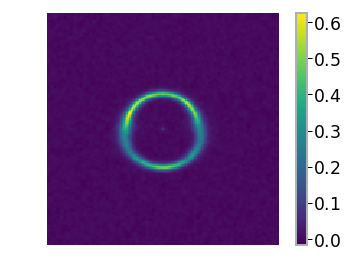

In [11]:
data = recon_src.d_ij(flat=False)
kwargs = dict(vmax=data.max(), vmin=data.min())
plt.imshow(data, **kwargs)
plt.colorbar()
plt.axis('off')
plt.show()


#### Reconstructed source plot

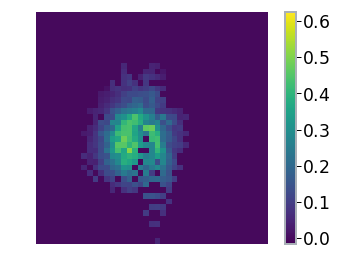

In [12]:
plt.imshow(recon_src.plane_map(), **kwargs)
plt.colorbar()
plt.axis('off')
plt.show()


#### Synthetic image plot

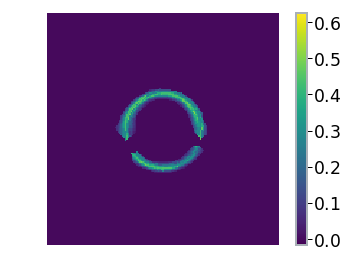

In [13]:
plt.imshow(recon_src.reproj_map(), **kwargs)
plt.colorbar()
plt.axis('off')
plt.show()


#### Masked data plot

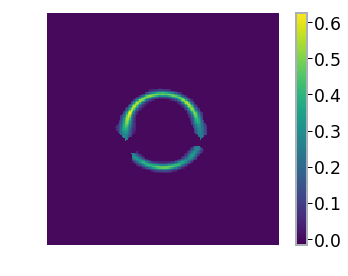

In [14]:
plt.imshow(recon_src.lens_map(mask=True), **kwargs)
plt.colorbar()
plt.axis('off')
plt.show()

#### Residual map plot

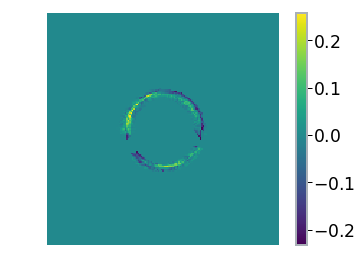

In [15]:
plt.imshow(recon_src.residual_map())  # data - synth
plt.colorbar()
plt.axis('off')
plt.show()

#### Residual statistics

In [16]:
%%skip True
print("Sum of squared residuals (ensemble avg)")
resid = recon_src.reproj_residual()
print(resid)

print("Sum of squared residuals (for the first three ensemble models)")
residuals = []
N = len(recon_src.gls.models)
for i in range(N):
    recon_src.chmdl(i)
    r = recon_src.reproj_residual()
    residuals.append(r)
print(residuals[:3])

print("0th, 10th, 25th, and 50th percentile values")
rhi10 = np.percentile(residuals, 10, interpolation='higher')
rhi25 = np.percentile(residuals, 25, interpolation='higher')
rhi50 = np.percentile(residuals, 50, interpolation='higher')
rlo = 0
print(rlo, rhi10, rhi25, rhi50)

#### Histogram of an ensemble's residual distribution
    

In [17]:
%%skip True

plt.hist(residuals, bins=35)
plt.axvline(rhi10)
plt.axvline(rhi25)
plt.axvline(rhi50)
plt.show()


#### Filtering and exporting the single state

In [18]:
%%skip True

def synth_filter(args, percentiles=[10, 25, 50]):
    pass

In [19]:
%%skip True

select10 = [i for i, r in enumerate(residuals) if rhi10 > r > rlo]
select25 = [i for i, r in enumerate(residuals) if rhi25 > r > rlo]
select50 = [i for i, r in enumerate(residuals) if rhi50 > r > rlo]
print("Number of selected models in 10th, 25th and 50th percentile")
print(len(select10))
print(len(select25))
print(len(select50))

In [20]:
%%skip True

dirname = os.path.dirname(state)
basename = ".".join(os.path.basename(state).split('.')[:-1])
save10 = dirname + '/' + basename + '_synthf10.state'
save25 = dirname + '/' + basename + '_synthf25.state'
save50 = dirname + '/' + basename + '_synthf50.state'
print("Names of filtered states...")
print(save10)
print(save25)
print(save50)


In [21]:
%%skip True

filtered_10 = filter_env(recon_src.gls, select10)
filtered_25 = filter_env(recon_src.gls, select25)
filtered_50 = filter_env(recon_src.gls, select50)
export_state(filtered_25, name=save25)
export_state(filtered_50, name=save50)


### Filtering ALL (previously unfiltered) states

In [22]:
%%skip True

# states loop
for k in keys:
    json = jsons[k][0]
    with open(json) as f:
        ml = MultiLens.from_json(f)
    for state in states[k]:
        print(json, state)

        args = (ml, state)
        kwargs = dict(M=20, verbose=1)
        recon_src = ReconSrc(*args, **kwargs)

        residuals = []
        for i in range(len(recon_src.gls.models)):
            recon_src.chmdl(i)
            r = recon_src.reproj_residual()
            residuals.append(r)
        print("\nNumber of residual models:")
        print(len(residuals))

        rhi10 = np.percentile(residuals, 10, interpolation='higher')
        rhi25 = np.percentile(residuals, 25, interpolation='higher')
        rhi50 = np.percentile(residuals, 50, interpolation='higher')
        rlo = 0
        print("\n0th, 10th, 25th, and 50th percentile values")
        print(rlo, rhi10, rhi25, rhi50)

        select10 = [i for i, r in enumerate(residuals) if rhi10 > r > rlo]
        select25 = [i for i, r in enumerate(residuals) if rhi25 > r > rlo]
        select50 = [i for i, r in enumerate(residuals) if rhi50 > r > rlo]

        print("\nNumber of selected models")
        print(len(select10))
        print(len(select25))
        print(len(select50))

        dirname = os.path.dirname(state)
        basename = ".".join(os.path.basename(state).split('.')[:-1])
        save10 = dirname + '/' + basename + '_synthf10.state'
        save25 = dirname + '/' + basename + '_synthf25.state'
        save50 = dirname + '/' + basename + '_synthf50.state'

        filtered_10 = filter_env(recon_src.gls, select10)
        filtered_25 = filter_env(recon_src.gls, select25)
        filtered_50 = filter_env(recon_src.gls, select50)

        export_state(filtered_10, name=save10)
        export_state(filtered_25, name=save25)
        export_state(filtered_50, name=save50)



### Filtering ALL (previously filtered) states

In [23]:
%%skip True

# filtered_states loop
for k in keys:
    json = jsons[k][0]
    with open(json) as f:
        ml = MultiLens.from_json(f)
    for state in filtered_states[k]:
        print(json, state)

        args = (ml, state)
        kwargs = dict(M=20, verbose=1)
        recon_src = ReconSrc(*args, **kwargs)

        residuals = []
        for i in range(len(recon_src.gls.models)):
            recon_src.chmdl(i)
            r = recon_src.reproj_residual()
            residuals.append(r)
        print("\nNumber of residual models")
        print(len(residuals))

        rhi10 = np.percentile(residuals, 10, interpolation='higher')
        rhi25 = np.percentile(residuals, 25, interpolation='higher')
        rhi50 = np.percentile(residuals, 50, interpolation='higher')
        rlo = 0
        print("\n0th, 10th, 25th, and 50th percentile values")
        print(rlo, rhi10, rhi25, rhi50)

        select10 = [i for i, r in enumerate(residuals) if rhi10 > r > rlo]
        select25 = [i for i, r in enumerate(residuals) if rhi25 > r > rlo]
        select50 = [i for i, r in enumerate(residuals) if rhi50 > r > rlo]

        print("\nNumber of subselected models")
        print(len(select10))
        print(len(select25))
        print(len(select50))

        dirname = os.path.dirname(state)
        basename = ".".join(os.path.basename(state).split('.')[:-1])
        save10 = dirname + '/' + basename + '_synthf10.state'
        save25 = dirname + '/' + basename + '_synthf25.state'
        save50 = dirname + '/' + basename + '_synthf50.state'

        filtered_10 = filter_env(recon_src.gls, select10)
        filtered_25 = filter_env(recon_src.gls, select25)
        filtered_50 = filter_env(recon_src.gls, select50)

        export_state(filtered_10, name=save10)
        export_state(filtered_25, name=save25)
        export_state(filtered_50, name=save50)
